## Data Exploration
The aim of this note book is to have a clearer idea of the dataset we will be working on. Also we will be modifying it to fit our needs.

For this test we will be using: `MarcOrfilaCarreras/spanish-news` from huggingface datasets. The dataset contains articles and it's category (politics, economics, etc...). We want to train a model than can predict articles categories (Text Classifier -> Focused in news).

#### Import all packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

#### Load dataset
This dataset has some columns that we don't need and some categories we are not interested in analysing. So after doing some exploration we will transform this dataset into one that fits our needs to solve this task. We may need to modify, remove or change some categories and drop some columns.

In [2]:
df = pd.read_csv("hf://datasets/MarcOrfilaCarreras/spanish-news/data.csv")

d:\Code\punto_medio\articles_classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Showing the main information about the dataset
print("Dataset information: ")
print(df.info())

# Checking if the dataset is balanced (Having same or similar amount of records for each category)
print("Categories count: ")
print(df['category'].value_counts())

print("Unique categories: ")
print(df['category'].unique())

Dataset information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   language   10200 non-null  object
 1   category   10200 non-null  object
 2   newspaper  10200 non-null  object
 3   hash       10200 non-null  object
 4   text       10200 non-null  object
dtypes: object(5)
memory usage: 398.6+ KB
None
Categories count: 
category
play            850
tech            850
medicine        850
astronomy       850
sport           850
fashion         850
alimentation    850
politics        850
military        850
religion        850
motor           850
economy         850
Name: count, dtype: int64
Unique categories: 
['play' 'tech' 'medicine' 'astronomy' 'sport' 'fashion' 'alimentation'
 'politics' 'military' 'religion' 'motor' 'economy']


#### Observations
After observing the main information about the dataset we can see:
* All categories/classes are balanced, we have 850 of each.
* There are 3 columns we are not interested: 'language', 'newspaper' and 'hash'.
* There categories we don't need or not at least in the way they currently exist. To adjust this we will combine 'fashion' and 'play' as 'entertainment'. In addition we will remove 3 categories: 'religion', 'motor' and 'astronomy', which have 0 relation on what we are looking to build.

#### Next steps
With this information in mind now we will start looking for anomalies or more deeper insigth about the data. We will analyze:
* Missing values in the dataset.
* Data duplication.
* Articles length and if there is any co-relation with certain categories (e.g. That all politics articles are extremely longer that others).

After this we will visualize our data using embeddings in combination with PCA to see how our data distributes in two or three dimensions to identify potential outliers.

In [4]:
# Check for missing values
missing_values = bool(df.isnull().values.any())
print(f"The total sum of missing values per column is: \n{df.isnull().sum()}. \n{'We are missing some values.' if missing_values else 'We are not missing any value.'}")

# Check for duplicates
duplicates = df[df.duplicated()]
print(f"\nDuplicates found:\n{duplicates}" if "Empty" in duplicates else "\nNo duplicates found.")

The total sum of missing values per column is: 
language     0
category     0
newspaper    0
hash         0
text         0
dtype: int64. 
We are not missing any value.

No duplicates found.


In [5]:
# Create a column with the number of characters
df['length_words'] = df['text'].str.split().str.len()

print("Articles length information: ")
print(df['length_words'].describe())


Articles length information: 
count    10200.000000
mean       680.546471
std        627.475470
min         68.000000
25%        368.000000
50%        539.000000
75%        837.000000
max      29746.000000
Name: length_words, dtype: float64


Length of words mean of articles from each category
category
astronomy        464.601176
fashion          509.644706
play             549.787059
sport            552.460000
economy          592.028235
politics         593.275294
motor            624.791765
tech             651.585882
alimentation     714.432941
religion         738.743529
military        1016.575294
medicine        1158.631765
Name: length_words, dtype: float64


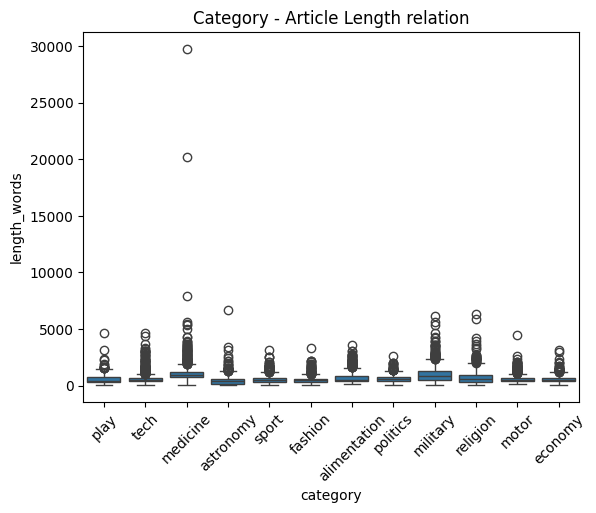

In [6]:
print("Length of words mean of articles from each category")
print(df.groupby('category')['length_words'].mean().sort_values())

sns.boxplot(x='category', y='length_words', data=df)
plt.xticks(rotation=45)
plt.title("Category - Article Length relation")
plt.show()

#### Results
After doing some analysis we conclude:
* The dataset is balanced as we knew.
* There are no duplicates nor null values present.
* Most of the articles range in the same length except for 2 or 3 outliers (we will remove them).
* Medicine and military articles tend to be longer.

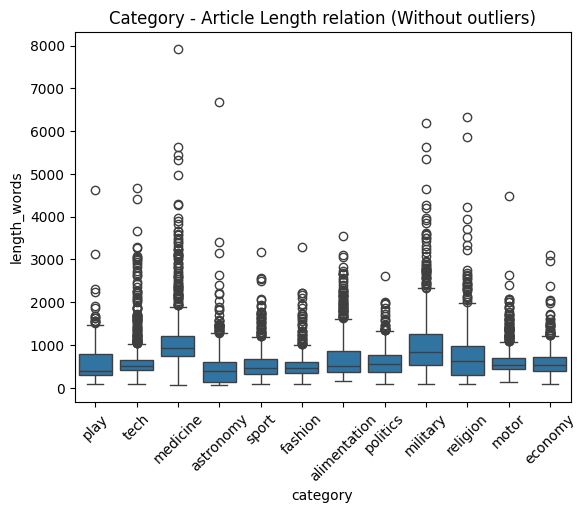

In [7]:
# Remove those 2 or 3 outliers inside medicine category
df = df[df["length_words"] <= 10000]

# And now we plot the data again
sns.boxplot(x='category', y='length_words', data=df)
plt.xticks(rotation=45)
plt.title("Category - Article Length relation (Without outliers)")
plt.show()

#### Setting up our final dataset
After observing our data we conclude that we need to perform some modifications in the dataset in order to fit our needs. Modifications:
* Remove columns we don't need ('language', 'newspaper' and 'hash').
* Remove 'religion', 'motor', 'astronomy' and 'alimentation', because we don't want those categories.
* Combine 'fashion' and 'play' into 'entertainment'.

After all this changes we will save this new dataset to be use for the model development.

In [ ]:
# Drop unwanted columns
df = df.drop(columns=["language", "newspaper", "hash", "length_words"])

# Remove all rows containing unwanted categories
categories_to_drop = ["religion", "motor", "astronomy", "alimentation"]
df = df[~df["category"].isin(categories_to_drop)]
print(f"Categories after drop: {df['category'].unique()}")

In [72]:
target_size_per_original = 425

# We store our articles in temp variables
fashion = df[df['category'] == 'fashion']
play = df[df['category'] == 'play']
others = df[~df['category'].isin(['fashion', 'play'])]

# Downsample each to target size to create entertainment
fashion_down = resample(fashion, replace=False, n_samples=target_size_per_original, random_state=42)
play_down = resample(play, replace=False, n_samples=target_size_per_original, random_state=42)

# Merge and relabel
entertainment = pd.concat([fashion_down, play_down])
entertainment['category'] = 'entertainment'

# Combine with other categories
df = pd.concat([others, entertainment]).reset_index(drop=True)

#### Save dataset

In [77]:
df.to_csv("../data/dataset.csv", index=False)

#### Conclusion

The data exploration process provided valuable insights into the dataset. We confirmed that the dataset is balanced, with no missing values or duplicates. Outliers in article lengths were identified and removed to ensure consistency.
 
Additionally, we refined the dataset by removing irrelevant columns and categories, and combining certain categories to better align with our classification goals. The final dataset is now clean, well-structured, and ready for use in model development.